In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv('data/train.csv')

# 1. Initial processing

## 1.1. Handle missing values

In [3]:
def determine_missing_values(data):
    """
    Calculate the missing value percentage from data DataFrame
    return a sorted Serier of predictor and its corresponding missing value percentage
    If the variable has zero missing value, it is not shown in the return
    """
    
    missing_value = []

    for column in data.columns:
        pct = data[column].isnull().sum()/1460

        if pct != 0:
            missing_value.append((column, pct))

    missing_value = sorted(missing_value, key=lambda x: x[1], reverse=True)

    pd_missing_value = pd.DataFrame(missing_value, columns=['Predictor', 'Percentage of missing value (%)'])
    pd_missing_value.set_index('Predictor', inplace=True)
    
    return pd_missing_value

pd_missing_value = determine_missing_values(data)

pd_missing_value

,Percentage of missing value (%)
Predictor,
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageType,0.055479
GarageYrBlt,0.055479
GarageFinish,0.055479


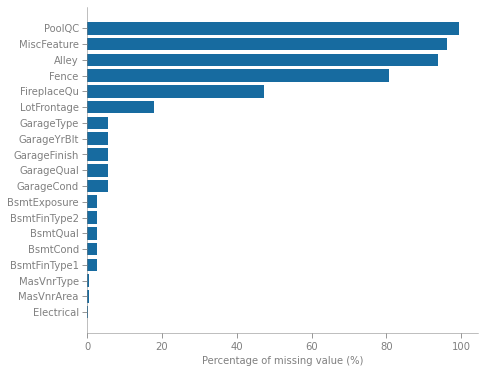

In [4]:
green = '#3FBDCB'
red = '#B6324F'
grey = '#CEADA4'
blue = '#176BA0'#'#4580A9'
lg = 'grey'

fig, ax = plt.subplots(1, figsize=(7,6))
y_pos = range(len(pd_missing_value))
ax.barh(y_pos, pd_missing_value['Percentage of missing value (%)']*100, color=blue)

ax.set_yticks(y_pos)
ax.set_yticklabels(pd_missing_value.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percentage of missing value (%)', color=lg)

ax.tick_params(axis='x',length=5, colors=lg)
ax.tick_params(axis='y',length=5, colors=lg)


ax.spines['bottom'].set_color(lg)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
ax.spines['left'].set_color(lg)
ax.spines['bottom'].set_color(lg)

plt.show()

In [5]:
# Do not drop any column, but filling NaN values
# Fill NaN with None:
def fill_na_with_None_and_Zero(columns_na, columns_zero, data):
    """
    Replace the missing value in data DataFrame with 'None'
    input is a list of column names
    """
    
    for column in columns_na:
        data[column] = data[column].fillna("None")

    for column in columns_zero:
        data[column] = data[column].fillna(0)

        
# Other filling methods:
def fill_na_other(data):
    data["BsmtExposure"] = data["BsmtExposure"].fillna("No") # NA means No Basement, same as No
    data['Exterior1st'] = data['Exterior1st'].fillna("VinylSd") 
    data['MSZoning'] = data['MSZoning'].fillna('RL')
    data['Exterior2nd'] = data['Exterior2nd'].fillna("VinylSd") 
    data['SaleType'] = data['SaleType'].fillna("WD") 
    data["GarageYrBlt"] = np.where(data["GarageYrBlt"].isnull(), data["YearBuilt"], data["GarageYrBlt"]) # use YearBuilt to replace NAN
    data["LotFrontage"] = data["LotFrontage"].fillna(data["LotFrontage"].mean()) # use mean value to replace NAN
    data['KitchenQual'] = data['KitchenQual'].fillna("TA") 
    data['Functional'] = data['Functional'].fillna("Typ") 


columns_na = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1", "MasVnrType", "Electrical"]
columns_zero = ["MasVnrArea", "BsmtFullBath", "BsmtHalfBath", "TotalBsmtSF", "GarageCars", "GarageArea"]
fill_na_with_None_and_Zero(columns_na, columns_zero, data)
fill_na_other(data)

## 1.2. Handle suspicious data

In [6]:
# identify suspicious data
suspicious_data_index = data[data['GrLivArea']>4000].index
suspicious_data_index

Int64Index([523, 691, 1182, 1298], dtype='int64')

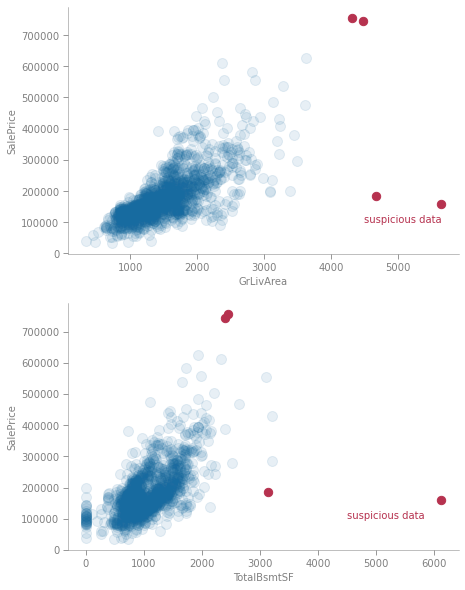

In [7]:
# define a function to plot suspicious data plot for each axes
def suspicious_data_plot(n, x_name, y_name):
    """
    Plot a scatter figure
    inputs are axes number, variable name, response name
    """
    
    # plot SalePrice over GrLivArea and TotalBsmtSF
    axes[n].scatter(data[x_name].drop(suspicious_data_index), data[y_name].drop(suspicious_data_index), color=blue, alpha=0.1, s=100)

    # plot suspicious data points
    for index in suspicious_data_index:
        axes[n].scatter(data[x_name].iloc[index], data[y_name].iloc[index], color=red, s=70)
    axes[n].text(4500,100000, "suspicious data", fontsize=10, c=red)

    # set label in plots
    axes[n].set_xlabel(x_name)
    axes[n].set_ylabel(y_name)

    # set axes in plots
    axes[n].tick_params(axis='x',length=5, colors=lg)
    axes[n].tick_params(axis='y',length=5, colors=lg)
    axes[n].xaxis.label.set_color(lg)
    axes[n].yaxis.label.set_color(lg)

    axes[n].spines['bottom'].set_color(lg)
    axes[n].spines['right'].set_visible(False)
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['bottom'].set_linewidth(.5)
    axes[n].spines['left'].set_linewidth(.5)
    axes[n].spines['left'].set_color(lg)
    axes[n].spines['bottom'].set_color(lg)

    
# plot the figure
fig, axes = plt.subplots(2, figsize=(7,10))
suspicious_data_plot(0, 'GrLivArea', 'SalePrice')
suspicious_data_plot(1, 'TotalBsmtSF', 'SalePrice')

plt.show()

In [8]:
data = data.drop(suspicious_data_index)
data.shape

(1456, 81)

## 1.3. Handle categorical variables

In [9]:
# reference: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# Some numerical variables are actually categorical variable
num_to_cat = {"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }

# Encode some categorical features as ordered numbers when there is information in the order
cat_to_num = {"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}


data = data.replace(num_to_cat)
data = data.replace(cat_to_num)


## 1.4. One-hot encoding

In [10]:
# split data into numerical and categorical variables
def split_data(data):
    categorical_columns = []
    numerical_columns = []

    for column in data.columns:
        if data[column].dtype=='O':
            categorical_columns.append(column)
        else:
            numerical_columns.append(column)

    return data[numerical_columns], data[categorical_columns]

data_num, data_cat = split_data(data)

In [11]:
def convert_dummies(data_num, data_cat):
    """
    Get dummies from categorical variables and combine these dummies with numerical variable
    Note that pd.get_dummies(data_cat, drop_first=True) sets the reference level based on alphabet which is not applicable in this case
    If the proportion of cases in the reference level is small, we will have severe multicollinearity issue.
    In order to mitigate the multicollinearity, we set the dummy with largest proportion of cases as reference level
    """

    for column in data_cat.columns:
        df_column_dummies = pd.get_dummies(data_cat[column], prefix=column)
        column_w_highest_f = data_cat[column].value_counts().index[0] # value_counts() sorts by default
        df_column_dummies = df_column_dummies.drop(column + '_' + column_w_highest_f, axis=1)
        data_num = pd.concat([data_num, df_column_dummies], axis=1)#ignore_index=False
    
    return data_num

data_processed = convert_dummies(data_num, data_cat)
data_processed.shape

(1456, 231)

## 1.4. Handle redundant variables

In [12]:
data_description = pd.read_csv('data_description_categories.csv', header=None)
data_description.fillna(method='ffill', inplace=True)
data_description = pd.DataFrame(data_description.values, index=[data_description.iloc[:,0],np.arange(83)]).drop(0, axis=1)
data_description.index.names = ['Category',' ']
data_description.rename(columns={1:'id', 2:'Variable'}, inplace=True)
data_description

id       Variable
Category                      
Type     0    1     MSSubClass
         1   15       BldgType
         2   16     HouseStyle
Location 3    2       MSZoning
         4   12   Neighborhood
...          ..            ...
Other    78  74    MiscFeature
         79  75        MiscVal
         80  78       SaleType
         81  79  SaleCondition
         82  80      SalePrice

[83 rows x 2 columns]

As we categorize the similar attributes/columns, we can see that some columns have very similar information, such as MSSubClass_MS90 and BldgType_Duplx are identical in MSSubClass and BldgType respectively. It would greatly affect multillinearity which would be discussed later. 

## 1.4.1. Multicollinearity

In [13]:
Y = data_processed['SalePrice']

data_processed = data_processed.drop(['Id','SalePrice'], axis=1)

X = sm.add_constant(data_processed)

In [14]:
pd.set_option('display.max_rows', 10)


VIF = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns, columns=['VIF Factor'])
VIF_sorted = VIF.sort_values(by='VIF Factor', ascending=False)

VIF_sorted[VIF_sorted['VIF Factor']>10]

/Users/siwei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor
BsmtFinSF1,inf
GarageFinish_None,inf
GarageType_None,inf
Exterior2nd_CBlock,inf
Exterior1st_CBlock,inf
...,...
MSSubClass_SC80,17.173273
Exterior2nd_Plywood,15.454995
Exterior1st_Plywood,12.897720
HouseStyle_1.5Unf,12.570652


In [15]:
# drop the redundant variables

# drop numerical redundant variables
# 1stFlrSF + 2ndFlrSF + LowQualFinSF = GrLivArea - drop 1stFlrSF + 2ndFlrSF
# BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF - drop BsmtFinSF1
# Correlation between GarageQual and GarageCond is 0.96 - drop GarageQual
X = X.drop(['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageQual', 'LowQualFinSF'], axis=1)

# drop categorical redundant variables
# GarageFinish_None = GarageType_None - drop GarageFinish_None
# Exterior2nd_CBlock = Exterior1st_CBlock - drop Exterior2nd_CBlock
# BldgType_Duplex = MSSubClass_SC90 - drop BldgType_Duplex
# Correlation between MiscFeature_Gar2 and MiscVal is 0.89 - drop MiscFeature_Gar2
# Correlation between GarageType_None and GarageCond is -0.94  - drop GarageType_None
X = X.drop(['GarageFinish_None', 'Exterior2nd_CBlock', 'MiscFeature_Gar2', 'BldgType_Duplex', 'GarageType_None'], axis=1)

In [16]:
VIF = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns, columns=['VIF Factor'])
VIF_sorted = VIF.sort_values(by='VIF Factor', ascending=False)

VIF_sorted[VIF_sorted['VIF Factor']>10]


,VIF Factor
const,2.973650e+06
SaleType_New,4.556813e+01
SaleCondition_Partial,4.520869e+01
BldgType_TwnhsE,4.484426e+01
Exterior2nd_MetalSd,4.170445e+01
...,...
Exterior2nd_Plywood,1.532483e+01
GrLivArea,1.279610e+01
Exterior1st_Plywood,1.274155e+01
HouseStyle_1.5Unf,1.211357e+01


We still have 29 high VIF variables out of 220 total variables. But we won't drop more. 

Although Multicollinearity could result in a higher p-values and it becomes difficult for us to examine the relationship between the each predictor and response, we will see that we can still identify the significant terms in model selection. (Also, all the estimations are still unbiased. But note that the standard error of prediction would increase.)

I will re-visit this issue when learn advanced regression methods.

## 1.5. Log of Y 


> Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.


In [17]:
Y = np.log1p(Y)

In [18]:
X.shape[1]

219

# 2. Model Selection

In [19]:
def fit_linear_reg(X,Y):
    """
    Fit the linear regression and return R-squared, AIC, BIC, list of variables if all the variables are significant.
    If p-value of any of the variables becomes larger than the threshold (after adding new predictor),
    we remove that insiginificant variable from model and fit the linear regression again till all variable are significant.
    """
    
    threshold_out = 0.05
    
    X_w_intercept = sm.add_constant(X)
    model = sm.OLS(Y, X_w_intercept)
    result = model.fit()
    
    # remove insignificant variables, ignoring intercept
    result_pvalues = result.pvalues[1:]
    
    if result_pvalues[result_pvalues>=threshold_out].empty:
        return result.rsquared, result.aic, result.bic, result.rsquared_adj, list(X.columns)
    elif result_pvalues[result_pvalues<threshold_out].empty:
        return 0, np.inf, np.inf, 0, []
    else:
        return fit_linear_reg(X[list(result_pvalues[result_pvalues<threshold_out].index)], Y)

In [20]:
from tqdm import tqdm

remaining_predictors = list(X.columns)[1:] #ignore intercept
selected_predictors = []
model_candidates = []
p = X.shape[1]-1

for k in tqdm(range(0, p)): # p
    
    R_squared = 0
        
    for n in range(0, p-k): #p-k
        predictor = remaining_predictors[n]
        temp_R_squared, temp_aic, temp_bic, temp_R_sqared_adj, temp_candidate = fit_linear_reg(X[selected_predictors+[predictor]], Y)
        
        if temp_R_squared > R_squared:
            R_squared = temp_R_squared
            aic = temp_aic
            bic = temp_bic
            R_sqared_adj = temp_R_sqared_adj
            candidate = temp_candidate
            index = n
            
    # update variable for next loop
    added_predictor = remaining_predictors.pop(index)

    # restore the model with the highest R squared
    selected_predictors = candidate
    model_candidates.append((selected_predictors, added_predictor, R_squared, aic, bic, R_sqared_adj))
            

100%|██████████| 218/218 [13:25<00:00,  3.69s/it]


In [21]:
pd.set_option('display.max_rows', None)

# convert model_candidates to a DataFrame
df_best_candidates = pd.DataFrame(model_candidates, columns=['Predictors', 'Added predictor', 'R_squared', 'AIC', 'BIC', 'Adjust R-sqared'])

# add a column with number of candidates
number_candidates = []
for i in df_best_candidates['Predictors'].values:
    number_candidates.append(len(i))

df_best_candidates['Candidates number'] = number_candidates


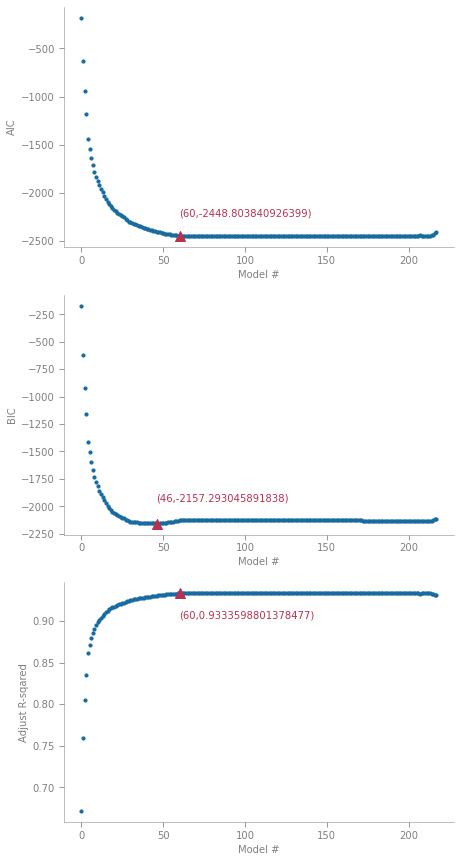

In [22]:
# define a function to plot AIC, BIC, R-squared adj over number of predictors
def AIC_BIC_R2_model_plot(n, y_name):
    """
    Plot a scatter figure
    inputs are axes number, variable name, response name
    """
    
    axes[n].scatter(df_best_candidates.index, df_best_candidates[y_name],color=blue, s=10)
    
    if y_name == 'Adjust R-sqared':
        max_r2_adj_index = df_best_candidates[y_name].idxmax()
        max_r2_adj = df_best_candidates[y_name].max()
        axes[n].scatter(max_r2_adj_index, max_r2_adj,color=red, marker='^', s=100)
        axes[n].text(max_r2_adj_index,max_r2_adj-0.03, f"({max_r2_adj_index},{max_r2_adj})", fontsize=10, c=red)
    else:
        min_parameter_index = df_best_candidates[y_name].idxmin()
        min_parameter = df_best_candidates[y_name].min()
        axes[n].scatter(min_parameter_index, min_parameter, color=red, marker='^', s=100)
        axes[n].text(min_parameter_index, min_parameter+200, f"({min_parameter_index},{min_parameter})", fontsize=10, c=red)
        
    # set label in plots
    axes[n].set_xlabel('Model #')
    axes[n].set_ylabel(y_name)

    # set axes in plots
    axes[n].tick_params(axis='x',length=5, colors=lg)
    axes[n].tick_params(axis='y',length=5, colors=lg)
    axes[n].xaxis.label.set_color(lg)
    axes[n].yaxis.label.set_color(lg)

    axes[n].spines['bottom'].set_color(lg)
    axes[n].spines['right'].set_visible(False)
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['bottom'].set_linewidth(.5)
    axes[n].spines['left'].set_linewidth(.5)
    axes[n].spines['left'].set_color(lg)
    axes[n].spines['bottom'].set_color(lg)

    
# plot the figure
fig, axes = plt.subplots(3, figsize=(7,15))
AIC_BIC_R2_model_plot(0, 'AIC')
AIC_BIC_R2_model_plot(1, 'BIC')
AIC_BIC_R2_model_plot(2, 'Adjust R-sqared')

plt.show()

# 3. Fitting the Selected Model

In [23]:
# Subset - AIC

AIC_index = df_best_candidates['AIC'].idxmin()
subset_AIC_columns = df_best_candidates.loc[AIC_index][0]

X_AIC = X[subset_AIC_columns]
X_AIC = sm.add_constant(X_AIC)
result_AIC = sm.OLS(Y, X_AIC).fit()


In [24]:
# Subset - BIC

BIC_index = df_best_candidates['BIC'].idxmin()
subset_BIC_columns = df_best_candidates.loc[BIC_index][0]

X_BIC = X[subset_BIC_columns]
X_BIC = sm.add_constant(X_BIC)
result_BIC = sm.OLS(Y, X_BIC).fit()


In [25]:
# Subset - Adjust R-sqared

R2_adj_index = df_best_candidates['Adjust R-sqared'].idxmax()
subset_R2_adj_columns = df_best_candidates.loc[R2_adj_index][0]

X_R2_adj = X[subset_R2_adj_columns]
X_R2_adj = sm.add_constant(X_R2_adj)
result_R2_adj = sm.OLS(Y, X_R2_adj).fit()


# 4. Evaluation of Model selected by BIC

## 4.1. Normality

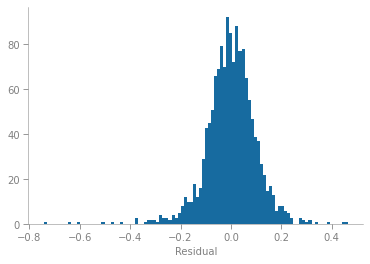

In [26]:
# Histogram of residuals (selected model)

fig, ax = plt.subplots()
ax.hist(result_BIC.resid, bins=100, color=blue)
ax.set_xlabel('Residual')

ax.tick_params(axis='x',length=5, colors=lg)
ax.tick_params(axis='y',length=5, colors=lg)
ax.xaxis.label.set_color(lg)
ax.yaxis.label.set_color(lg)

ax.spines['bottom'].set_color(lg)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
ax.spines['left'].set_color(lg)
ax.spines['bottom'].set_color(lg)

plt.show()

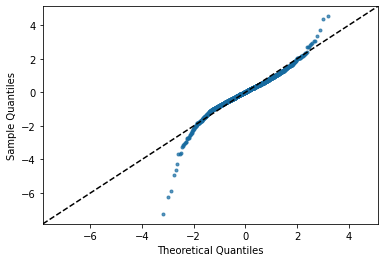

In [27]:
# QQ plot (selected model)

pp = sm.ProbPlot(result_BIC.resid, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor=blue, markeredgecolor=blue, alpha=0.7)
sm.qqline(qq.axes[0], line='45', fmt='k--')

# sm.qqplot(result.resid)

It clearly shows the non-normality in the distribution of residual. We will address this later.

## 4.2. Influential points

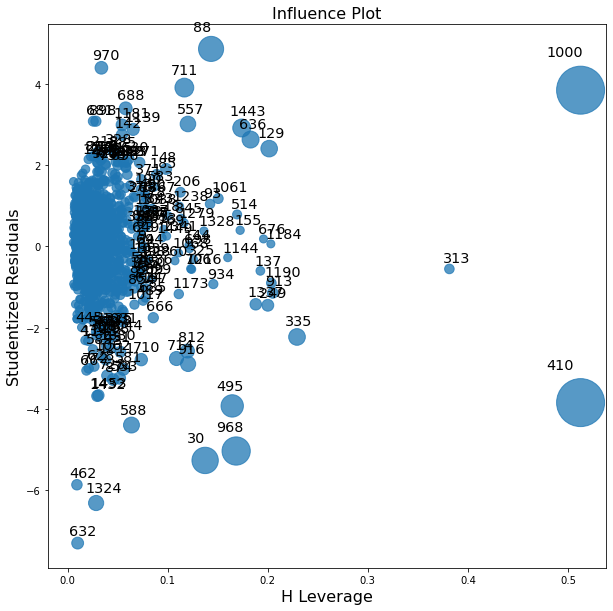

In [28]:
# Influence plot

infl = result_BIC.get_influence()
fig, ax = plt.subplots(figsize=(10,10))
fig=sm.graphics.influence_plot(result_BIC, ax=ax, criterion="cooks") 

In [29]:
import scipy.stats as st

df = result_BIC.df_resid
thre_stud = st.t.ppf(0.975,df=df)

print(f"The criteria for high influential points were set as studentized residuals > {thre_stud:.2f} and h_ii > 0.3")

#calculate hii manually
# from numpy.linalg import inv
# X_BIC_wo_const = X_BIC.drop('const', axis=1).values
# H = X_BIC_wo_const.dot(inv(X_BIC_wo_const.T.dot(X_BIC_wo_const))).dot(X_BIC_wo_const.T)
# Hii = np.diag(H)
# df_Hii = pd.DataFrame({"Hii": Hii} )


The criteria for high influential points were set as studentized residuals > 1.96 and h_ii > 0.3


Data #1000 and #410 are high influential points. We will remove these points for comparison.

## 4.3. Heteroscedasticity

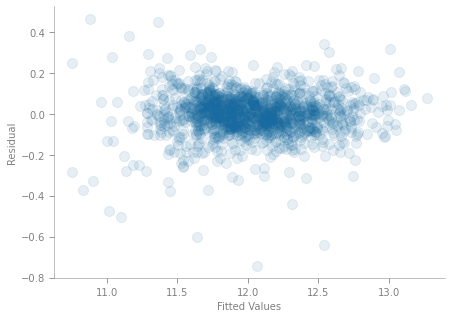

In [30]:
# Fitted Values vs. Residuals Plot (selected model)

p = result_BIC.fittedvalues
res = result_BIC.resid

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(p,res, color=blue, alpha=0.1, s=100)
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residual")
# axes[0].title("Fitted Values vs. Residuals")

ax.tick_params(axis='x',length=5, colors=lg)
ax.tick_params(axis='y',length=5, colors=lg)
ax.xaxis.label.set_color(lg)
ax.yaxis.label.set_color(lg)

ax.spines['bottom'].set_color(lg)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
ax.spines['left'].set_color(lg)
ax.spines['bottom'].set_color(lg)

plt.show()

In [31]:
# Breusch-Pagan for Heteroscedasticity (selected model)

from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(result_BIC.resid, result_BIC.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))
# Heteroscedasticity exists

{'LM Statistic': 209.16040734794728, 'LM-Test p-value': 1.147445701877762e-22}


## 4.4. Collinearity

In [32]:
VIF = pd.DataFrame([variance_inflation_factor(X_BIC.values, i) for i in range(X_BIC.shape[1])], index=X_BIC.columns, columns=['VIF Factor'])
VIF_sorted = VIF.sort_values(by='VIF Factor', ascending=False)

VIF_sorted[VIF_sorted['VIF Factor']>10]

# no collinearity exist in the selected model

,VIF Factor
const,28178.458086


## 4.5. Linearity between Y and X

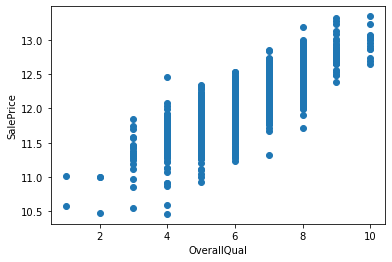

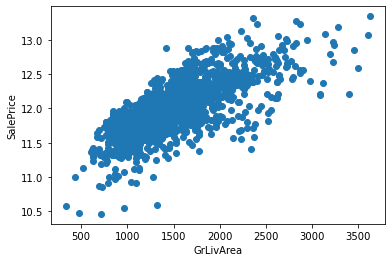

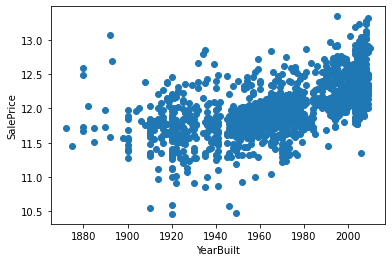

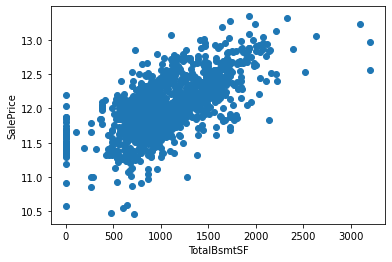

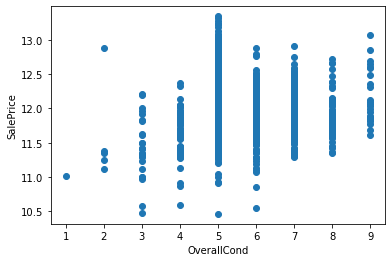

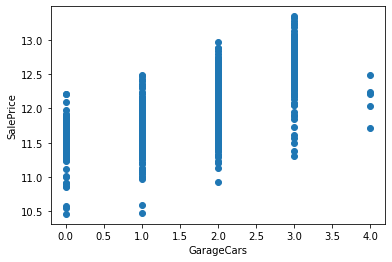

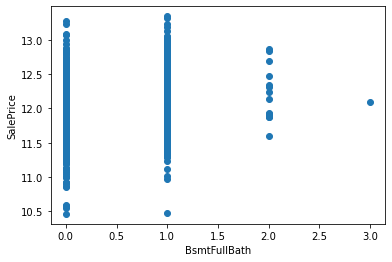

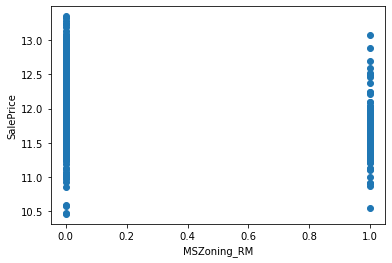

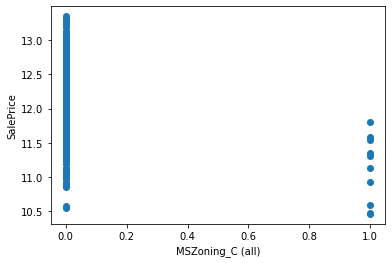

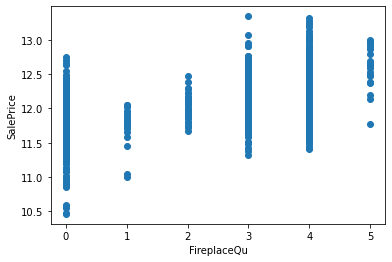

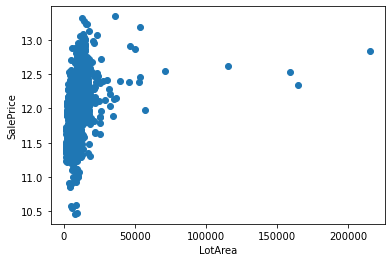

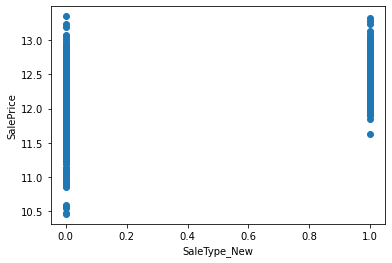

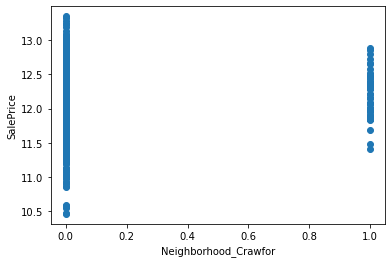

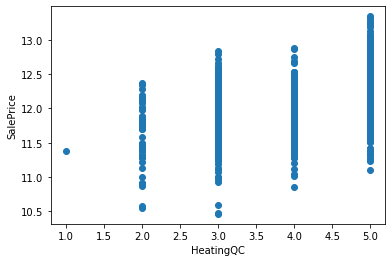

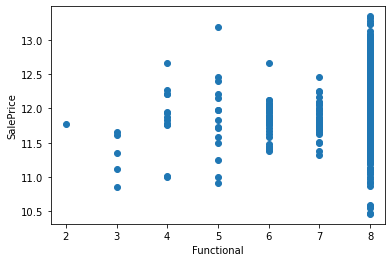

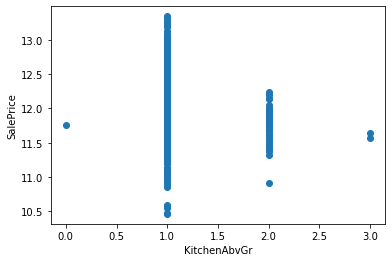

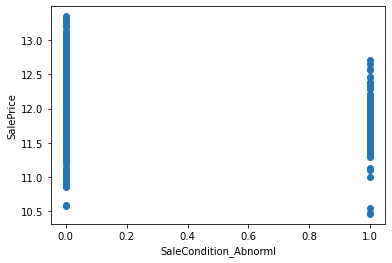

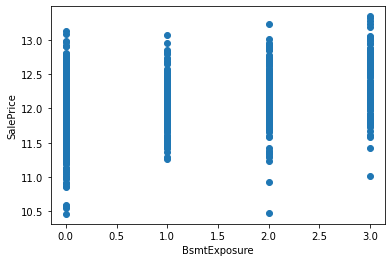

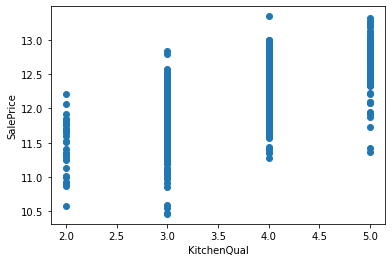

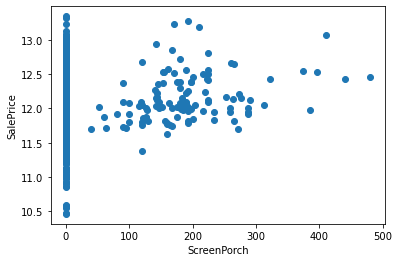

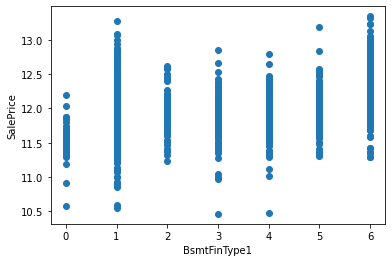

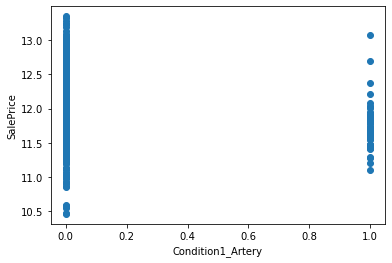

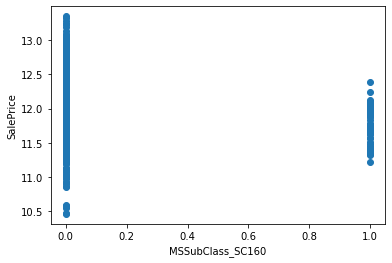

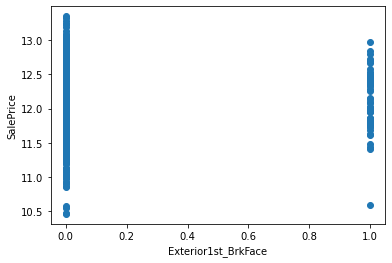

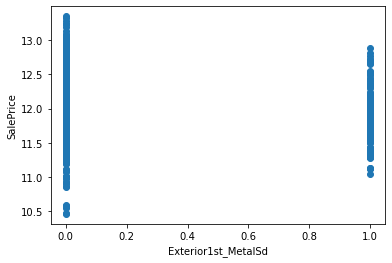

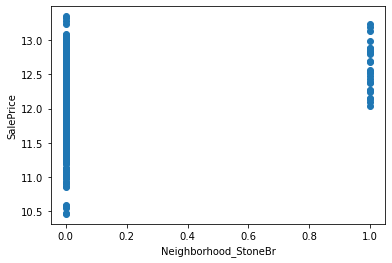

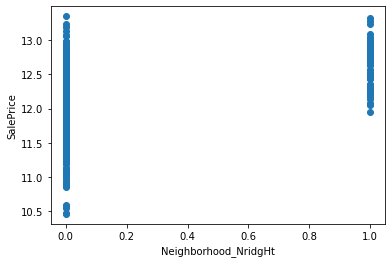

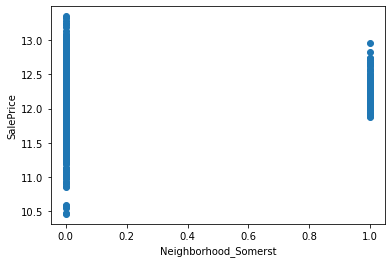

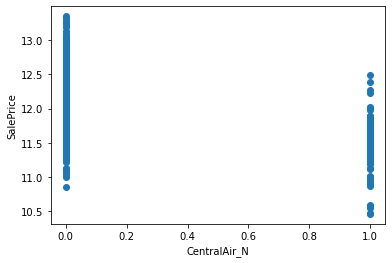

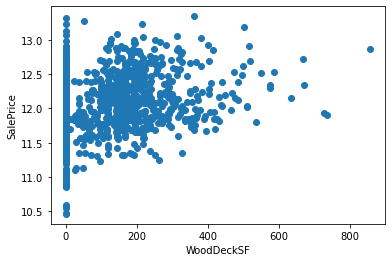

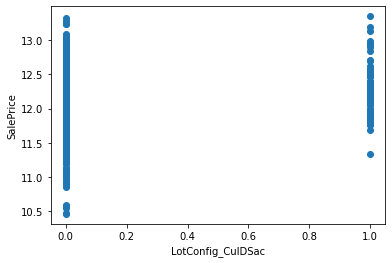

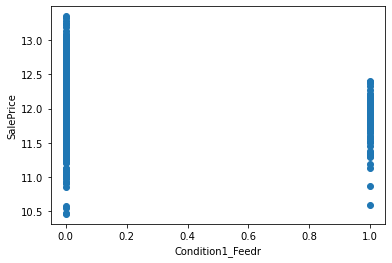

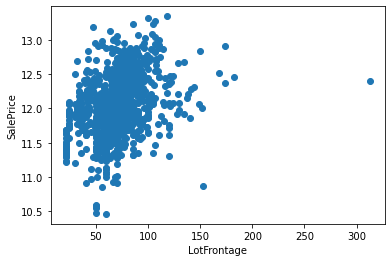

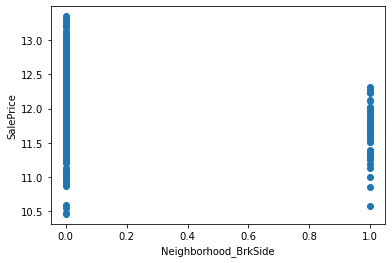

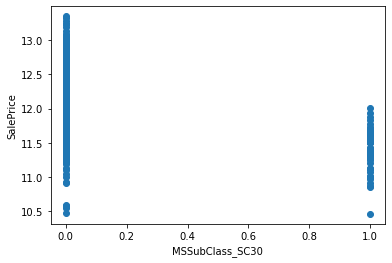

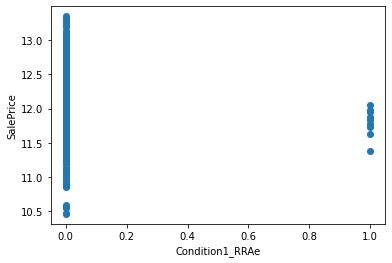

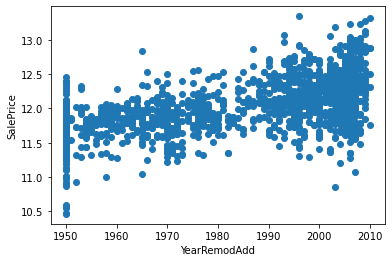

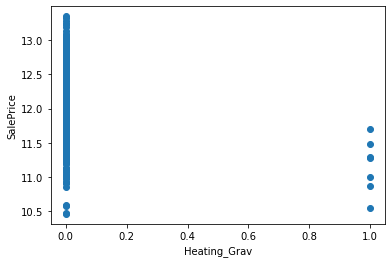

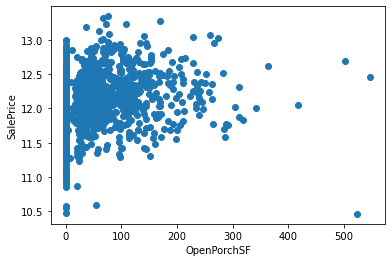

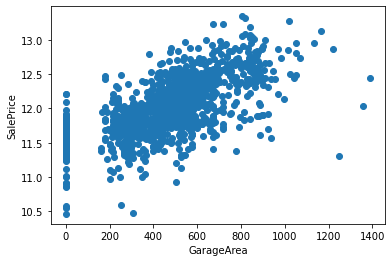

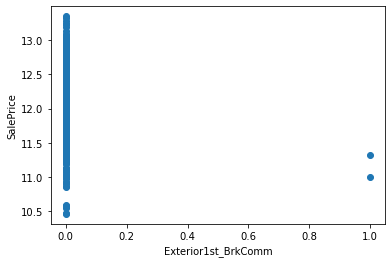

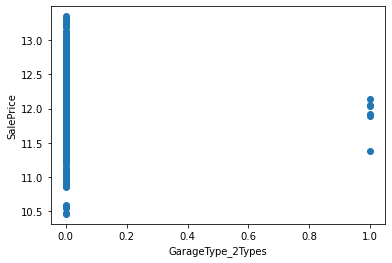

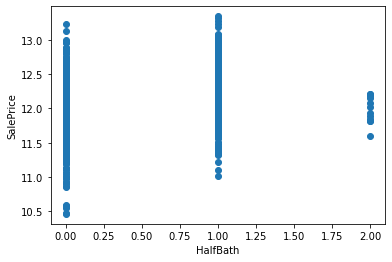

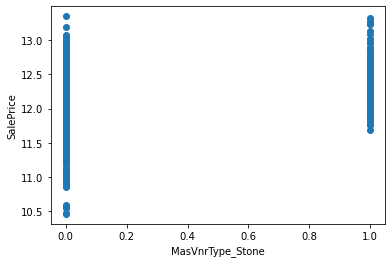

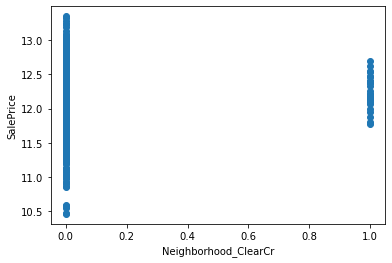

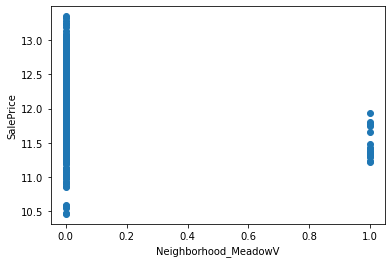

In [33]:
for i, column in enumerate(X_BIC.columns.values[1:]):
    plt.figure()
    plt.scatter(data_processed[column], Y.values)
    plt.xlabel(column)
    plt.ylabel("SalePrice")
    plt.show()

# 5. Solution for the issues in model evalution

## 5.1. Linearity issue - log-log transformation

After scrutinize the plot between Y and X, we found that LotArea suffers from severe non-linearity. Thus, we apply log transformation on LotArea.

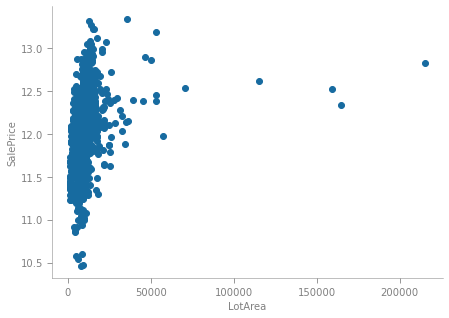

In [34]:
def x_y_plot(column):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(X_BIC[column],Y.values, color=blue)
    ax.set_xlabel(column)
    ax.set_ylabel("SalePrice")

    ax.tick_params(axis='x',length=5, colors=lg)
    ax.tick_params(axis='y',length=5, colors=lg)
    ax.xaxis.label.set_color(lg)
    ax.yaxis.label.set_color(lg)

    ax.spines['bottom'].set_color(lg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(.5)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['left'].set_color(lg)
    ax.spines['bottom'].set_color(lg)

    plt.show()
    
x_y_plot("LotArea")

In [35]:
X_BIC['LotArea'] = np.log1p(X_BIC['LotArea'])

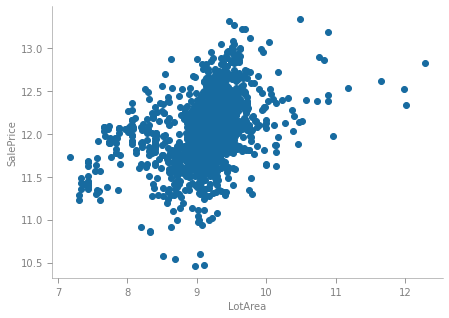

In [36]:
x_y_plot("LotArea")

## 5.2. Influential points - temporary remove points for comparison

In [37]:
X_BIC_drop = X_BIC.drop([1000, 410], axis=0)
Y_drop = Y.drop([1000, 410], axis=0)

# 6. Final Model

In [38]:
# Subset - BIC

X_BIC_drop = sm.add_constant(X_BIC_drop)
result_BIC = sm.OLS(Y_drop, X_BIC_drop).fit()
result_BIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     446.1
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:09:44   Log-Likelihood:                 1269.0
No. Observations:                1454   AIC:                            -2446.
Df Residuals:                    1408   BIC:                            -2203.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.4182      0.471      9.373      0.000       3.493       5.343
OverallQual               0.0509      0.004     13.341      0.000       0.043       0.058
GrLivArea                 0.0003   9.65e-06     27.232      0.000       0.000       0.000
YearBuilt                 0.0020      0.000     10.397      0.000       0.002       0.002
TotalBsmtSF               0.0001   9.58e-06     11.847      0.000    9.47e-05       0.000
OverallCond               0.0336      0.003     10.361      0.000       0.027       0.040
GarageCars                0.0330      0.009      3.822      0.000       0.016       0.050
BsmtFullBath              0.0334      0.007      4.906      0.000       0.020       0.047
MSZoning_RM              -0.0279      0.010     -2.799      0.005      -0.047      -0.008
MSZoning_C (all)         -0.3759      0.035    -10.853      0.000      -0.444      -0.308
FireplaceQu               0.0082      0.002      4.278      0.000       0.004       0.012
LotArea                   0.0696      0.009      7.865      0.000       0.052       0.087
SaleType_New              0.0537      0.012      4.621      0.000       0.031       0.076
Neighborhood_Crawfor      0.1394      0.016      8.714      0.000       0.108       0.171
HeatingQC                 0.0150      0.004      4.113      0.000       0.008       0.022
Functional                0.0336      0.004      7.630      0.000       0.025       0.042
KitchenAbvGr             -0.0578      0.014     -4.102      0.000      -0.085      -0.030
SaleCondition_Abnorml    -0.0635      0.011     -5.718      0.000      -0.085      -0.042
BsmtExposure              0.0127      0.003      4.142      0.000       0.007       0.019
KitchenQual               0.0224      0.006      3.485      0.001       0.010       0.035
ScreenPorch               0.0002   5.04e-05      4.087      0.000       0.000       0.000
BsmtFinType1              0.0098      0.002      5.629      0.000       0.006       0.013
Condition1_Artery        -0.0775      0.016     -4.820      0.000      -0.109      -0.046
MSSubClass_SC160         -0.0330      0.018     -1.877      0.061      -0.068       0.001
Exterior1st_BrkFace       0.0897      0.016      5.784      0.000       0.059       0.120
Exterior1st_MetalSd       0.0296      0.008      3.642      0.000       0.014       0.046
Neighborhood_StoneBr      0.1266      0.022      5.722      0.000       0.083       0.170
Neighborhood_NridgHt      0.0689      0.015      4.594      0.000       0.039       0.098
Neighborhood_Somerst      0.0529      0.014      3.744      0.000       0.025       0.081
CentralAir_N             -0.0437      0.014     -3.212      0.001      -0.070      -0.017
WoodDeckSF             8.546e-05   2.42e-05      3.535      0.000     3.8e-05       0.000
LotConfig_CulDSac      

We have 45 parameters and 1454 observations. The ratio is 32.311. Thus, the sample size can be considered as large enough to estimate the coefficient of the parameters. 

## 6.1. Detect overfitting

In [39]:
# We used the function defined in Reference to calculate the predict R-squared
# https://gist.github.com/benjaminmgross/d71f161d48378d34b6970fa6d7378837
def press_statistic(y_true, y_pred, xs):
    """
    Calculation of the `Press Statistics <https://www.otexts.org/1580>`_
    """
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res/den)
    return sqr.sum()

def predicted_r2(y_true, y_pred, xs):
    """
    Calculation of the `Predicted R-squared <https://rpubs.com/RatherBit/102428>`_
    """
    press = press_statistic(y_true=y_true,
                            y_pred=y_pred,
                            xs=xs
    )

    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - press / sst
 
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

predict_R2 = predicted_r2(Y_drop.values, result_BIC.predict(), X_BIC_drop.values)

print(f"The predicted R-squared is {predict_R2:.3f} and regular R-squared is {result_BIC.rsquared:.3f}")

The predicted R-squared is 0.928 and regular R-squared is 0.934


As there is only a minor discrepancy between predicted R-squared and regular R-sqular, it seems that we did not overfit the model.

# 7. Prediction

In [43]:
data_test = pd.read_csv('data/test.csv')

In [44]:
# handle missing values
columns_na = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1", "MasVnrType", "Electrical"]
columns_zero = ["MasVnrArea", "BsmtFullBath", "BsmtHalfBath", "TotalBsmtSF", "GarageCars", "GarageArea"]
fill_na_with_None_and_Zero(columns_na, columns_zero, data_test)
fill_na_other(data_test)

# handle categorical variable
data_test = data_test.replace(num_to_cat)
data_test = data_test.replace(cat_to_num)

# get dummies
data_num, data_cat = split_data(data_test)
data_test_processed = convert_dummies(data_num, data_cat)

# drop the redundant variables
X_test = sm.add_constant(data_test_processed)
X_test = X_test.drop(['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageQual', 'LowQualFinSF'], axis=1)
X_test = X_test.drop(['GarageFinish_None', 'Exterior2nd_CBlock', 'MiscFeature_Gar2', 'BldgType_Duplex', 'GarageType_None'], axis=1)

# log transformation of LotArea
X_test['LotArea'] = np.log1p(X_test['LotArea'])


In [45]:
# obtain prediction of SalePrice

X_test_BIC = X_test[subset_BIC_columns]
X_test_BIC = sm.add_constant(X_test_BIC)
ypred = result_BIC.predict(X_test_BIC)
ypred =np.expm1(ypred)
ypred.to_csv('submission.csv')

In [46]:
ypred

0       1.185040e+05
1       1.581787e+05
2       1.767317e+05
3       1.983522e+05
4       2.025682e+05
5       1.686881e+05
6       1.761616e+05
7       1.589775e+05
8       1.961828e+05
9       1.189674e+05
10      1.933504e+05
11      9.900741e+04
12      9.538403e+04
13      1.427408e+05
14      1.153199e+05
15      3.664227e+05
16      2.574708e+05
17      2.899411e+05
18      2.875353e+05
19      4.920177e+05
20      3.497500e+05
21      2.234578e+05
22      1.743963e+05
23      1.642963e+05
24      1.850545e+05
25      1.934200e+05
26      3.265844e+05
27      2.381372e+05
28      1.943210e+05
29      2.209287e+05
30      1.939039e+05
31      8.900819e+04
32      1.849821e+05
33      2.762351e+05
34      2.795128e+05
35      2.295093e+05
36      1.770850e+05
37      1.666720e+05
38      1.651645e+05
39      1.540540e+05
40      1.721662e+05
41      1.479609e+05
42      2.815075e+05
43      2.463467e+05
44      2.255668e+05
45      1.984028e+05
46      2.690302e+05
47      1.994